In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model3 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 2

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34AuxSimple2(n_classes=1, n_aux_classes=8)
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.05 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_aux_simple2_aug_kfold_cv{CV}_phase1')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-17 17:16:12.166246] Train Epoch: 0 [0/3199 (0%)]	Average loss: 0.020912
[2018-10-17 17:16:35.425034] Train Epoch: 0 [1800/3199 (56%)]	Average loss: 0.015004
[2018-10-17 17:16:35.425034] Train Epoch: 0	IoU: 0.405993
Saved model at 0 (IoU: 0.40599250936329584)
[2018-10-17 17:17:01.706702] Train Epoch: 1 [0/3199 (0%)]	Average loss: 0.008836
[2018-10-17 17:17:24.942291] Train Epoch: 1 [1800/3199 (56%)]	Average loss: 0.008996
[2018-10-17 17:17:24.942291] Train Epoch: 1	IoU: 0.545693
Saved model at 1 (IoU: 0.5456928838951312)
[2018-10-17 17:17:51.487406] Train Epoch: 2 [0/3199 (0%)]	Average loss: 0.009766
[2018-10-17 17:18:14.702389] Train Epoch: 2 [1800/3199 (56%)]	Average loss: 0.008486
[2018-10-17 17:18:14.702389] Train Epoch: 2	IoU: 0.645443
Saved model at 2 (IoU: 0.6454431960049938)
[2018-10-17 17:18:40.734989] Train Epoch: 3 [0/3199 (0%)]	Average loss: 0.005073
[2018-10-17 17:19:03.987734] Train Epoch: 3 [1800/3199 (56%)]	Average loss: 0.007961
[2018-10-17 17:19:03.987734] Tra

[2018-10-17 17:44:02.800298] Train Epoch: 34 [0/3199 (0%)]	Average loss: 0.003237
[2018-10-17 17:44:26.122049] Train Epoch: 34 [1800/3199 (56%)]	Average loss: 0.002792
[2018-10-17 17:44:26.122049] Train Epoch: 34	IoU: 0.744944
[2018-10-17 17:44:51.904394] Train Epoch: 35 [0/3199 (0%)]	Average loss: 0.003114
[2018-10-17 17:45:15.200959] Train Epoch: 35 [1800/3199 (56%)]	Average loss: 0.003042
[2018-10-17 17:45:15.200959] Train Epoch: 35	IoU: 0.769538
Saved model at 35 (IoU: 0.7695380774032459)
[2018-10-17 17:45:41.237584] Train Epoch: 36 [0/3199 (0%)]	Average loss: 0.002760
[2018-10-17 17:46:04.549177] Train Epoch: 36 [1800/3199 (56%)]	Average loss: 0.003098
[2018-10-17 17:46:04.549177] Train Epoch: 36	IoU: 0.771286
Saved model at 36 (IoU: 0.7712858926342072)
[2018-10-17 17:46:30.612863] Train Epoch: 37 [0/3199 (0%)]	Average loss: 0.002358
[2018-10-17 17:46:53.917001] Train Epoch: 37 [1800/3199 (56%)]	Average loss: 0.002498
[2018-10-17 17:46:53.917001] Train Epoch: 37	IoU: 0.788889
Save

In [10]:
def criterion_phase2(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.05 * classification_loss

In [11]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 20
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_aux_simple2_aug_kfold_cv{CV}_phase2')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [12]:
model = train_phase2(model, 60, train_loader, val_loader)

[2018-10-17 17:55:31.056735] Train Epoch: 0 [0/3199 (0%)]	Average loss: 0.018511
[2018-10-17 17:55:58.697308] Train Epoch: 0 [1800/3199 (56%)]	Average loss: 0.031985
[2018-10-17 17:55:58.697308] Train Epoch: 0	IoU: 0.702871
Saved model at 0 (IoU: 0.7028714107365793)
[2018-10-17 17:56:28.119802] Train Epoch: 1 [0/3199 (0%)]	Average loss: 0.035273
[2018-10-17 17:56:55.771964] Train Epoch: 1 [1800/3199 (56%)]	Average loss: 0.030245
[2018-10-17 17:56:55.771964] Train Epoch: 1	IoU: 0.749688
Saved model at 1 (IoU: 0.7496878901373284)
[2018-10-17 17:57:25.128802] Train Epoch: 2 [0/3199 (0%)]	Average loss: 0.017605
[2018-10-17 17:57:52.745925] Train Epoch: 2 [1800/3199 (56%)]	Average loss: 0.026948
[2018-10-17 17:57:52.745925] Train Epoch: 2	IoU: 0.775905
Saved model at 2 (IoU: 0.7759051186017478)
[2018-10-17 17:58:22.436538] Train Epoch: 3 [0/3199 (0%)]	Average loss: 0.020050
[2018-10-17 17:58:50.033984] Train Epoch: 3 [1800/3199 (56%)]	Average loss: 0.022800
[2018-10-17 17:58:50.033984] Trai

[2018-10-17 18:27:43.250346] Train Epoch: 34 [0/3199 (0%)]	Average loss: 0.010459
[2018-10-17 18:28:10.901534] Train Epoch: 34 [1800/3199 (56%)]	Average loss: 0.010307
[2018-10-17 18:28:10.901534] Train Epoch: 34	IoU: 0.812984
[2018-10-17 18:28:40.043384] Train Epoch: 35 [0/3199 (0%)]	Average loss: 0.015286
[2018-10-17 18:29:07.607769] Train Epoch: 35 [1800/3199 (56%)]	Average loss: 0.009837
[2018-10-17 18:29:07.607769] Train Epoch: 35	IoU: 0.814482
[2018-10-17 18:29:36.695512] Train Epoch: 36 [0/3199 (0%)]	Average loss: 0.009706
[2018-10-17 18:30:04.298475] Train Epoch: 36 [1800/3199 (56%)]	Average loss: 0.009669
[2018-10-17 18:30:04.298475] Train Epoch: 36	IoU: 0.811236
[2018-10-17 18:30:33.427406] Train Epoch: 37 [0/3199 (0%)]	Average loss: 0.010304
[2018-10-17 18:31:01.019868] Train Epoch: 37 [1800/3199 (56%)]	Average loss: 0.009714
[2018-10-17 18:31:01.019868] Train Epoch: 37	IoU: 0.804994
[2018-10-17 18:31:30.192706] Train Epoch: 38 [0/3199 (0%)]	Average loss: 0.008373
[2018-10-1

In [13]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

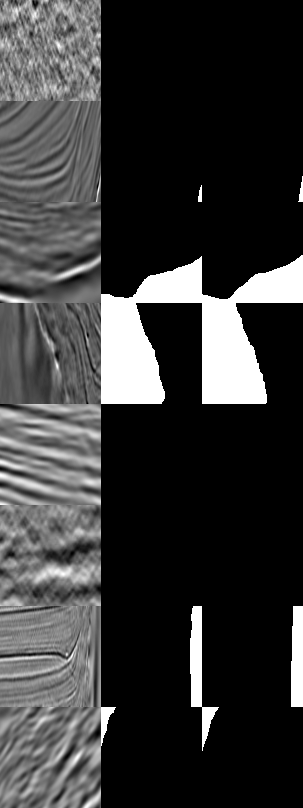

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

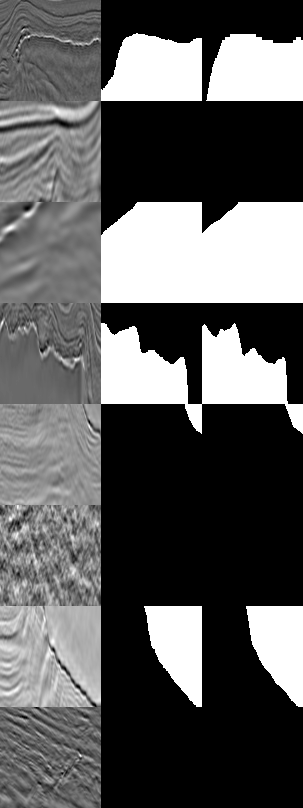

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

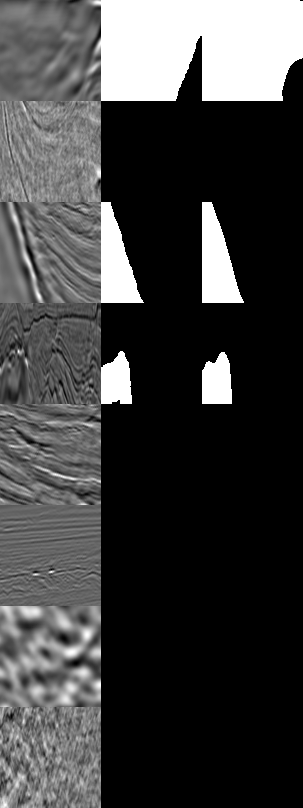

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

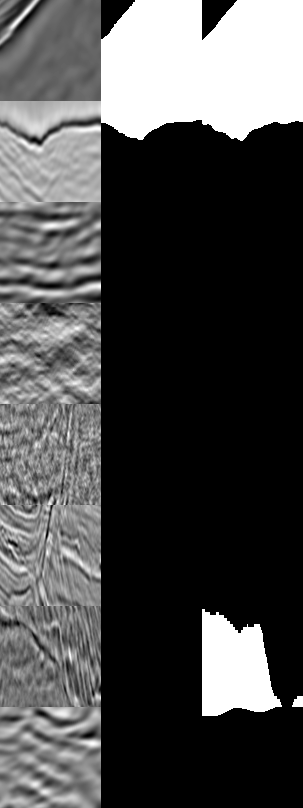

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)